(array([4.80000e+01, 1.51000e+03, 2.03710e+04, 1.19163e+05, 3.03032e+05,
        3.43272e+05, 1.71441e+05, 3.74040e+04, 3.57800e+03, 1.81000e+02]),
 array([60.51396819, 63.32700027, 66.14003236, 68.95306444, 71.76609652,
        74.57912861, 77.39216069, 80.20519277, 83.01822486, 85.83125694,
        88.64428902]),
 <BarContainer object of 10 artists>)

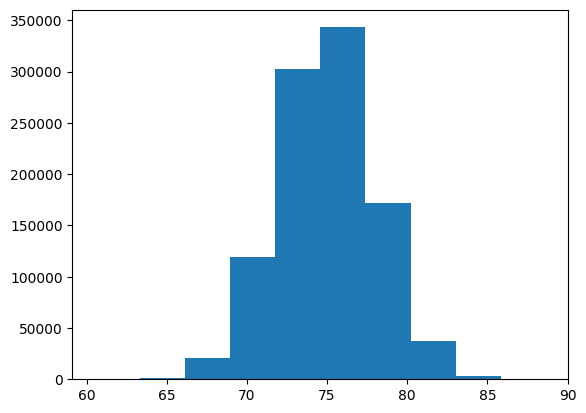

In [207]:
x = np.abs(np.random.normal(loc=75, scale=3, size=1000000))
# graficar x
plt.hist(x)

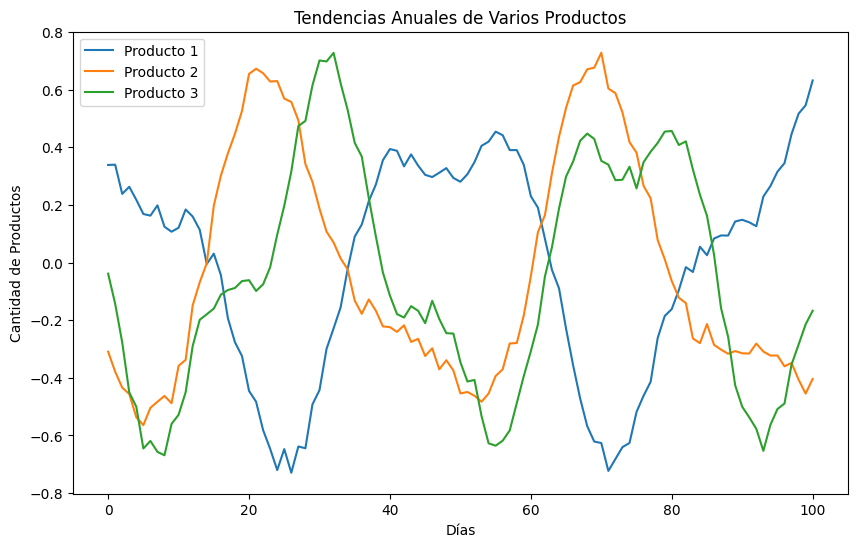

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def generate_time_series(batch_size, steps):

    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, steps) - 0.5)   # + noise

    return series[..., np.newaxis].astype(np.float32)


def generate_dataset(batch_size):

    products = np.arange(batch_size) # productos ID
    dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D') # fechas
    sales_series = generate_time_series(batch_size, len(dates)) # ventas
    promotion = np.random.choice([0, 1], size=(batch_size, len(dates)), p=[0.8, 0.2]) # 1:promocion, 0:nada
    country = np.random.randint(0, 3, (batch_size, len(dates))) # 3 paises
    province = np.random.randint(0, 5, (batch_size, len(dates))) # 5 provincias en cada pais
    city = np.random.randint(0, 10, (batch_size, len(dates))) # 10 ciudades en cada provincia
    store = np.random.randint(0, 3, (batch_size, len(dates))) # 3 tiendas en cada ciudad
    season = np.random.randint(0, 4, (batch_size, len(dates))) # 4 estaciones
    max_temp = np.random.normal(loc=30, scale=5, size=(batch_size, len(dates))) # temperatura maxima en grados celsius
    min_temp = np.random.normal(loc=7, scale=5, size=(batch_size, len(dates))) # temperatura minima en grados celsius
    rain = np.random.choice([0, 1], size=(batch_size, len(dates)), p=[0.8, 0.2]) # lluvia o no
    snow = np.random.choice([0, 1], size=(batch_size, len(dates)), p=[0.95, 0.05]) # nieve o no
    wind = np.abs(np.random.normal(loc=0, scale=20, size=(batch_size, len(dates)))) # velocidad del viento en km/h
    humidity = np.abs(np.random.normal(loc=20, scale=20, size=(batch_size, len(dates)))) # humedad en %
    unemployment = np.random.normal(loc=5, scale=2, size=(batch_size, len(dates))) # desempleo en %
    inflation = np.random.normal(loc=5, scale=1, size=(batch_size, len(dates))) # inflacion en %
    interest_rate = np.random.normal(loc=5.2, scale=0.5, size=(batch_size, len(dates))) # tasa de interes del banco central
    pbi = np.random.normal(loc=1000, scale=10, size=(batch_size, len(dates))) # producto bruto interno en millardos de dolares (1 billon = 1000 millardos, 1 millardo = 1000 millones)
    oil_price = np.random.normal(loc=75, scale=3, size=(batch_size, len(dates))) # precio del barril de petroleo en dolares

    dataset = pd.DataFrame(columns=products)




    # DataFrame vacío para almacenar los datos de ventas
    df_ventas = pd.DataFrame(index=dates)


    for _ in range(batch_size):

        dataset.append(tendencia)

    return np.array(dataset)



steps = 100        # numero de datos por serie de tiempo, numero de dias.
batch_size = 3     # numero de series de tiempo, numero de productos.
series = generate_time_series(batch_size, steps + 1)



# Visualizar los datos
plt.figure(figsize=(10, 6))
for i in range(batch_size):
    plt.plot(series[i], label=f'Producto {i + 1}')

plt.title('Tendencias Anuales de Varios Productos')
plt.xlabel('Días')
plt.ylabel('Cantidad de Productos')
plt.legend()
plt.show()


In [2]:
import pandas as pd
import numpy as np

# Lista de productos
productos = ['Manzanas', 'Plátanos', 'Naranjas', 'Peras', 'Uvas']

# Rango de fechas para el historial de ventas
fechas = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')

# DataFrame vacío para almacenar los datos de ventas
df_ventas = pd.DataFrame(index=fechas)

# Generar datos de ventas para cada producto con una tendencia
for producto in productos:
    # Generar una tendencia aleatoria para cada producto
    tendencia = np.random.randn(len(fechas)).cumsum()
    
    # Generar datos de ventas sumando la tendencia a un valor base
    ventas = 100 + tendencia
    
    # Agregar los datos de ventas al DataFrame
    df_ventas[producto] = ventas

# Guardar el DataFrame en un archivo CSV
df_ventas.to_csv('dataset_ventas.csv', index_label='Fecha')

print("Se ha creado el dataset de ventas correctamente.")


Se ha creado el dataset de ventas correctamente.
